In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
#from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt
import json
import os
from sklearn import preprocessing

C:\Users\milliman\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\milliman\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\milliman\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\milliman\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWa

In [4]:
#data preprocessing: threshold for anomaly, nFeatures
thresh = 0.5
p_w = 1
nFeatures = 1

In [5]:
with open ('NAB/labels/combined_windows.json','r') as label_file:
    gt_labels = json.load(label_file)

In [6]:
#include_dir = ['realAdExchange','realAWSCloudwatch','realKnownCause','realTraffic','realTweets']
include_dir = ['realAdExchange']

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 1/20
1462/1462 [==============================] - 1s 934us/sample - loss: 0.1641 - acc: 6.8399e-04
Epoch 2/20
1462/1462 [==============================] - 1s 882us/sample - loss: 0.1308 - acc: 6.8399e-04
Epoch 3/20
1462/1462 [==============================] - 1s 851us/sample - loss: 0.1261 - acc: 6.8399e-04
Epoch 4/20
1462/1462 [==============================] - 1s 870us/sample - loss: 0.1271 - acc: 6.8399e-04
Epoch 5/20
1462/1462 [==============================] - 1s 858us/sample - loss: 0.1242 - acc: 6.8399e-04
Epoch 6/20
1462/1462 [==============================] - 1s 866us/sample - loss: 0.1202 - acc: 6.8399e-04
Epoch 7/20
1462/1462 [==============================] - 1s 853us/sample - loss: 0.1217 - acc: 6.8399e-04s - loss: 0.1233 
Epoch 8/20
1462/1462 [==============================] - 1s 890us/sample - loss: 0.1207 - acc: 6.8399e-04
Epoch 9/20
1462/1462 [===

C:\Users\milliman\anaconda3\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars


Epoch 1/20
1522/1522 [==============================] - 0s 122us/sample - loss: 0.0445 - acc: 6.5703e-04
Epoch 2/20
1522/1522 [==============================] - 0s 79us/sample - loss: 0.0406 - acc: 6.5703e-04
Epoch 3/20
1522/1522 [==============================] - 0s 88us/sample - loss: 0.0395 - acc: 6.5703e-04
Epoch 4/20
1522/1522 [==============================] - 0s 77us/sample - loss: 0.0393 - acc: 6.5703e-04
Epoch 5/20
1522/1522 [==============================] - 0s 84us/sample - loss: 0.0394 - acc: 6.5703e-04
Epoch 6/20
1522/1522 [==============================] - 0s 77us/sample - loss: 0.0385 - acc: 6.5703e-04
Epoch 7/20
1522/1522 [==============================] - 0s 84us/sample - loss: 0.0386 - acc: 6.5703e-04
Epoch 8/20
1522/1522 [==============================] - 0s 79us/sample - loss: 0.0387 - acc: 6.5703e-04
Epoch 9/20
1522/1522 [==============================] - 0s 75us/sample - loss: 0.0385 - acc: 6.5703e-04
Epoch 10/20
1522/1522 [==============================] - 0s 73u

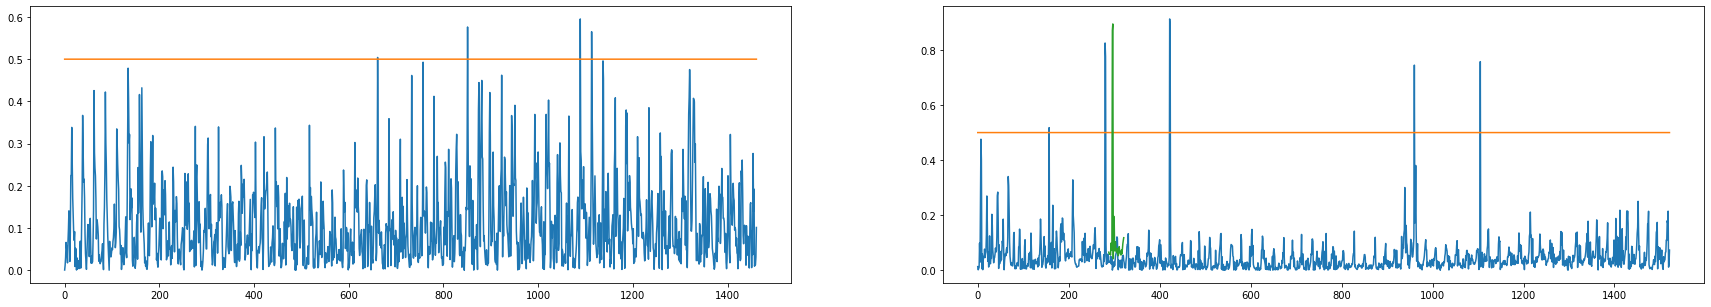

In [7]:
cnt = 0
plt.figure(figsize=(30,60))
metric_dict = {}

for each_dir in os.listdir('NAB/data'):    
    if os.path.isdir(os.path.join('NAB/data',each_dir)) and each_dir in include_dir:
        subdir = os.path.join('NAB/data',each_dir)
        for each_file in os.listdir(subdir):
            ts_data = pd.read_csv(os.path.join(subdir, each_file), sep=",")
            file_addr = each_dir + '/' + each_file
            
            #Get anomaly
            gt_anomaly=gt_labels[file_addr]
            
            #Set anomaly label column
            ts_data['anomaly_window'] = np.where((ts_data['timestamp'] >= gt_anomaly[0][0]) & (ts_data['timestamp'] <= gt_anomaly[0][1]), 1, 0)
            window_size = sum(ts_data['anomaly_window']) / len(gt_anomaly)
            hparam_list = [{'w': int(sum(ts_data['anomaly_window']) / len(gt_anomaly)), 
                'filter_size_1':32, 
                'filter_size_2':32, 
                'kernel_size_1': int(window_size / 2), # Not described in the paper
                'kernel_size_2': int(window_size / 2), # Not described in the paper
                'max_pool_size_1': int(window_size / 2), # Not described in the paper
                'max_pool_size_2': int(window_size / 2), # Not described in the paper
                'FC_size':50}]
            # Min max normalization
            scaler = preprocessing.MinMaxScaler()
            scaler_fit = scaler.fit(np.expand_dims(ts_data['value'], axis=-1))
            ts_data['value'] = scaler_fit.transform(np.expand_dims(ts_data['value'], axis=-1))
                           
            # Hyper parameters
            w = hparam_list[0]['w']
            filter_size_1 = hparam_list[0]['filter_size_1']
            filter_size_2 = hparam_list[0]['filter_size_2']
            kernel_size_1 = hparam_list[0]['kernel_size_1']
            kernel_size_2 = hparam_list[0]['kernel_size_2']
            max_pool_size_1 = hparam_list[0]['max_pool_size_1']
            max_pool_size_2 = hparam_list[0]['max_pool_size_2']
            FC_size = hparam_list[0]['FC_size']
            
            # Prepare data to the format required for deepant
            for i in range(ts_data.shape[0] - w + 1 - p_w):
                window = np.expand_dims(np.array(ts_data['value'].iloc[i:i+w]), axis = 0)    
                label = np.expand_dims(ts_data['value'].iloc[i+w:i+w+p_w], axis = 0)
                if i == 0:
                    windows = window
                    labels = label
                else:
                    windows = np.append(windows, window, axis=0)
                    labels = np.append(labels, label, axis = 0)
            vector_x = np.expand_dims(windows, axis = -1)
            y = np.expand_dims(ts_data['value'].iloc[w:ts_data.shape[0]],axis=-1)
            # Construct a model
            model = tf.keras.Sequential([    
                layers.Conv1D(filter_size_1, kernel_size_1, activation='relu', input_shape=(w,nFeatures), padding='valid'),
                layers.MaxPooling1D(max_pool_size_1, strides=1, padding='same'),
                layers.Conv1D(filter_size_2, kernel_size_2, activation='relu', padding='same'),
                layers.Flatten(),
                layers.Dense(FC_size),
                layers.Dense(p_w)
            ])
            model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                    metrics=['accuracy'])
            #Train a model
            model.fit(vector_x, y, epochs = 20)
            
            #After training get predictions
            predictions = model.predict(vector_x)
            
            i = int(cnt / 2)
            j = cnt % 2
            ax = plt.subplot2grid((10,2), (i,j))
            ax.plot(((y-predictions)**2)**0.5)
            ax.plot(([0.5] * len(y)))
            ax.plot(ts_data[ts_data['anomaly_window']==1]['value'].iloc[w:ts_data.shape[0]])
            
            #Calculate metrics
            predictions = model.predict(vector_x)
            anomaly_score = ((y-predictions)**2)**0.5
            anomaly_score = np.resize(anomaly_score, new_shape=(anomaly_score.shape[0])) > thresh
            
            # get metrics
            pos = anomaly_score>thresh
            gt = np.resize(ts_data['anomaly_window'].iloc[w:ts_data.shape[0]], new_shape=(anomaly_score.shape[0]))
            precision =  sum(pos * gt)/sum(pos)
            recall = sum(pos * gt) / sum(gt)            
            f = 2 * precision * recall / (precision + recall)
            metrics = {'precision':precision, 'recall':recall, 'f':f}
            metric_dict[file_addr] = metrics
            
            cnt += 1
plt.show()    

In [153]:
metric_dict

{'realAdExchange/exchange-2_cpc_results.csv': {'precision': 0.0,
  'recall': 0.0,
  'f': nan},
 'realAdExchange/exchange-3_cpc_results.csv': {'precision': 0.3333333333333333,
  'recall': 0.04,
  'f': 0.07142857142857142}}

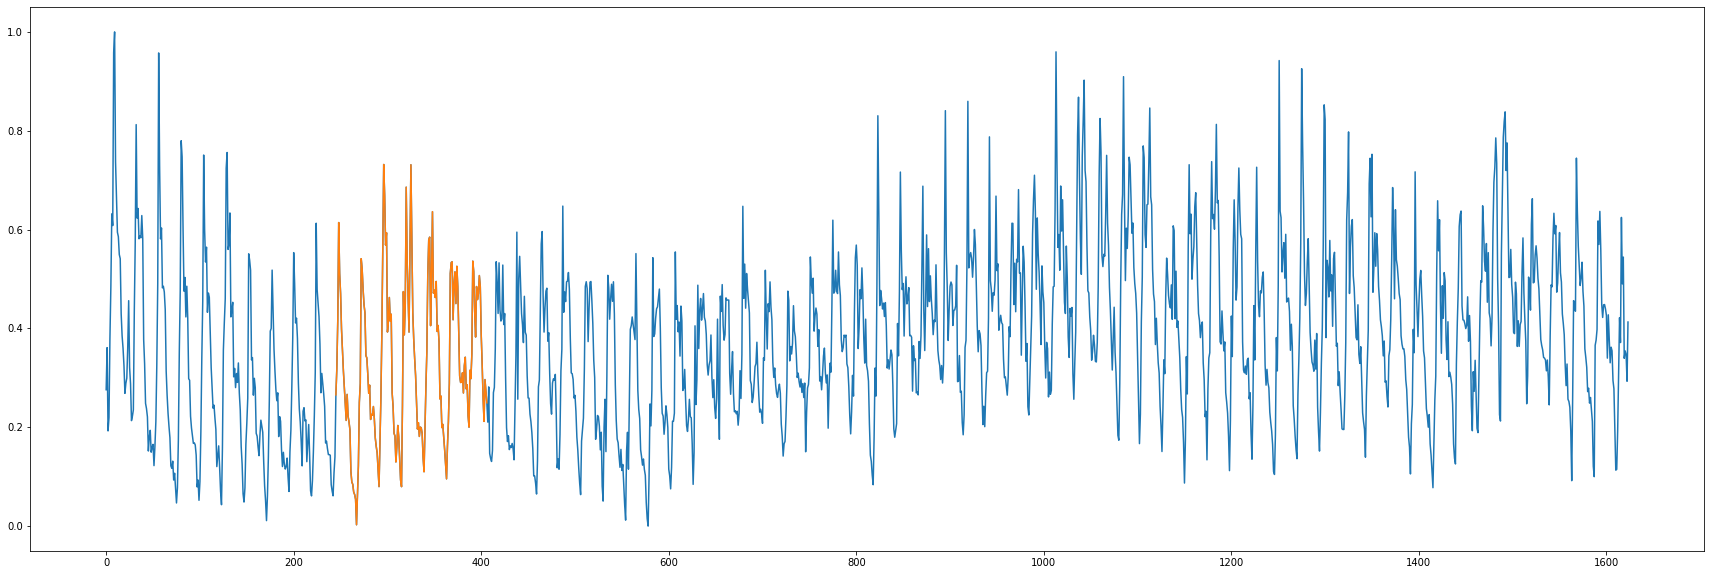

In [135]:
plt.figure(figsize=(30,10))
plt.plot(ts_data['value'])
plt.plot(ts_data[ts_data['anomaly_window']==1]['value'])